In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# 1. 简单线性回归

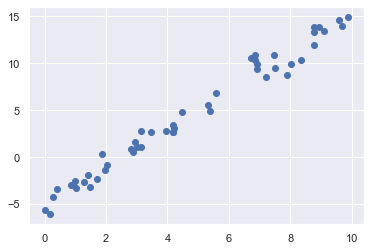

In [2]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = 2 * x - 5 + rng.randn(50)
plt.scatter(x, y);

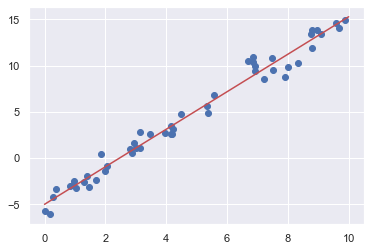

In [3]:
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit,c='r');

In [4]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     2.027208810360695
Model intercept: -4.998577085553202


In [5]:
rng = np.random.RandomState(1)
X = 10 * rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.])+rng.randn(100)

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.6562333465768129
[ 1.48159542 -1.97622428  0.97258042]


# 2. 基函数回归

**1.多项式基函数**

In [8]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2, 3, 4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, None])

array([[ 2.,  4.,  8.],
       [ 3.,  9., 27.],
       [ 4., 16., 64.]])

In [9]:
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7),
                           LinearRegression())

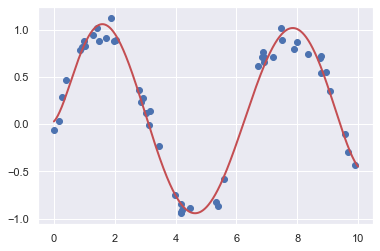

In [11]:
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit,c='r',linewidth=2);

**2. 高斯基函数**

例如，有一种常用的拟合模型方法使用的并不是一组多项式 基函数，而是一组高斯基函数。

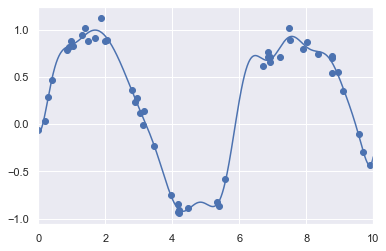

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
    
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y) / width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
        
    def fit(self, X, y=None):
        # create N centers spread along the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
        
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                 self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                            LinearRegression())
gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);

# 3.正则化

虽然在线性回归模型中引入基函数会让模型变得更加灵活，但是也很容易造成过拟合。例如，如果选择了太多高斯基函数，那么最终的拟合结果看起来可能并不好。

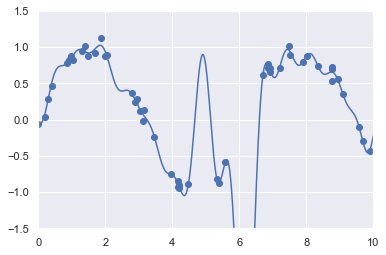

In [14]:
model = make_pipeline(GaussianFeatures(30),
                      LinearRegression())
model.fit(x[:, np.newaxis], y)

plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

plt.xlim(0, 10)
plt.ylim(-1.5, 1.5);

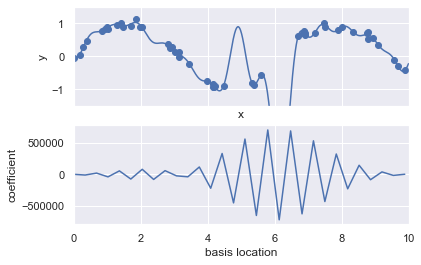

In [16]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    
    if title:
        ax[0].set_title(title)

    ax[1].plot(model.steps[0][1].centers_,
               model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
              ylabel='coefficient',
              xlim=(0, 10))
    
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

**1. 岭回归（L2范数正则化）**

正则化最常见的形式可能就是岭回归（ridge regression，或者L2 范数正则化），有时也被称为吉洪诺夫正则化（Tikhonov regularization）。其处理方法是对模型系数平方和（L2 范数）进行惩罚

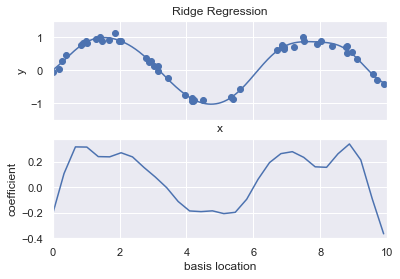

In [17]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))
basis_plot(model, title='Ridge Regression')

参数α 是控制最终模型复杂度的关键。如果α → 0，那么模型就恢复到标准线性回归结果；如果α → ∞，那么所有模型响应都会被压制。

**2. Lasso正则化（L1范数）**

另一种常用的正则化被称为Lasso，其处理方法是对模型系数绝对值的和（L1 范数）进行惩罚,虽然它在形式上非常接近岭回归，但是其结果与岭回归差别很大。例如，由于其几何特性，Lasso 正则化倾向于构建稀疏模型；也就是说，它更喜欢将模型系数设置为0。

模型系数的L1- 范数正则化实现的

E:\python\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


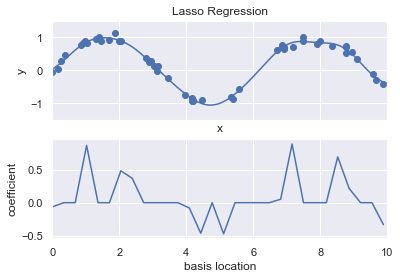

In [18]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))
basis_plot(model, title='Lasso Regression')

In [25]:
# 节假日

In [26]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
holidays

DatetimeIndex(['2012-01-02', '2012-01-16', '2012-02-20', '2012-05-28',
               '2012-07-04', '2012-09-03', '2012-10-08', '2012-11-12',
               '2012-11-22', '2012-12-25', '2013-01-01', '2013-01-21',
               '2013-02-18', '2013-05-27', '2013-07-04', '2013-09-02',
               '2013-10-14', '2013-11-11', '2013-11-28', '2013-12-25',
               '2014-01-01', '2014-01-20', '2014-02-17', '2014-05-26',
               '2014-07-04', '2014-09-01', '2014-10-13', '2014-11-11',
               '2014-11-27', '2014-12-25', '2015-01-01', '2015-01-19',
               '2015-02-16', '2015-05-25', '2015-07-03', '2015-09-07',
               '2015-10-12', '2015-11-11', '2015-11-26', '2015-12-25',
               '2016-01-01'],
              dtype='datetime64[ns]', freq=None)

(8, 17)

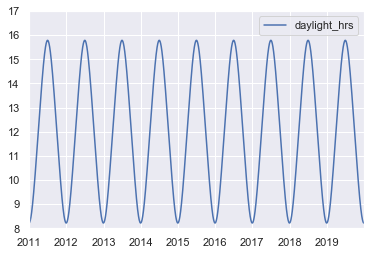

In [31]:
# 标准天文计算白昼时间
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2010, 12, 31)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

# 新建数据框
import pandas as pd
daily=pd.DataFrame(index=pd.date_range('2011-01-01','2019-12-31'))
daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot()
plt.ylim(8, 17)
#daily